In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build(width, height, depth, classes):
	# initialize the model along with the input shape to be
	# "channels last" and the channels dimension itself
	model = Sequential()
	inputShape = (height, width, depth)
	chanDim = -1
 
	# if we are using "channels first", update the input shape
	# and channels dimension
	if K.image_data_format() == "channels_first":
		inputShape = (depth, height, width)
		chanDim = 1
	# CONV => RELU => POOL
	model.add(Conv2D(32, (3, 3), padding="same",
		input_shape=inputShape))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(3, 3)))
	model.add(Dropout(0.25))
	# (CONV => RELU) * 2 => POOL
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(64, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	# (CONV => RELU) * 2 => POOL
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(Conv2D(128, (3, 3), padding="same"))
	model.add(Activation("relu"))
	model.add(BatchNormalization(axis=chanDim))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Dropout(0.25))
	# first (and only) set of FC => RELU layers
	model.add(Flatten())
	model.add(Dense(1024))
	model.add(Activation("relu"))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
 
	# softmax classifier
	model.add(Dense(classes))
	model.add(Activation("softmax"))
 
	# return the constructed network architecture
	return model        


In [3]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [4]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 98
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)
 
# initialize the data and labels
data = []
labels = []
 
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
path = '/home/jorgel/Documents/faceRec/dataset'
imagePaths = sorted(list(paths.list_images(path)))
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [5]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    
    data.append(image)
 
    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    
    labels.append(label)


In [6]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))
data
 
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("labels {}".format(labels))
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)


[INFO] data matrix: 347.76MB
labels [[0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]


In [7]:
print("Size {}".format(len(labels)))
print(labels.shape)
print(trainX.shape, testX.shape)
print(testX.shape, testY.shape)

Size 1610
(1610, 7)
(1288, 96, 96, 3) (322, 96, 96, 3)
(322, 96, 96, 3) (322, 7)


In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

In [9]:
# initialize the model
print("[INFO] compiling model...")
model = build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
 
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)


[INFO] compiling model...
[INFO] training network...
Epoch 1/98
40/40 [==============================] - 82s 2s/step - loss: 3.0996 - acc: 0.1430 - val_loss: 2.6963 - val_acc: 0.1677
Epoch 2/98
40/40 [==============================] - 72s 2s/step - loss: 2.5451 - acc: 0.1602 - val_loss: 2.7783 - val_acc: 0.1708
Epoch 3/98
40/40 [==============================] - 68s 2s/step - loss: 2.4691 - acc: 0.1578 - val_loss: 2.6928 - val_acc: 0.2391
Epoch 4/98
40/40 [==============================] - 66s 2s/step - loss: 2.3973 - acc: 0.1898 - val_loss: 2.3506 - val_acc: 0.2236
Epoch 5/98
40/40 [==============================] - 62s 2s/step - loss: 2.2334 - acc: 0.2172 - val_loss: 2.4051 - val_acc: 0.1708
Epoch 6/98
40/40 [==============================] - 61s 2s/step - loss: 2.1483 - acc: 0.2345 - val_loss: 2.2505 - val_acc: 0.2795
Epoch 7/98
40/40 [==============================] - 68s 2s/step - loss: 1.9850 - acc: 0.3094 - val_loss: 2.0464 - val_acc: 0.3634
Epoch 8/98
40/40 [===================

Epoch 62/98
40/40 [==============================] - 59s 1s/step - loss: 0.6322 - acc: 0.7602 - val_loss: 0.9310 - val_acc: 0.7019
Epoch 63/98
40/40 [==============================] - 57s 1s/step - loss: 0.6807 - acc: 0.7540 - val_loss: 0.8508 - val_acc: 0.7453
Epoch 64/98
40/40 [==============================] - 58s 1s/step - loss: 0.6271 - acc: 0.7617 - val_loss: 0.9782 - val_acc: 0.7174
Epoch 65/98
40/40 [==============================] - 59s 1s/step - loss: 0.6532 - acc: 0.7641 - val_loss: 1.1179 - val_acc: 0.6460
Epoch 66/98
40/40 [==============================] - 58s 1s/step - loss: 0.5664 - acc: 0.7742 - val_loss: 1.2484 - val_acc: 0.6056
Epoch 67/98
40/40 [==============================] - 58s 1s/step - loss: 0.6183 - acc: 0.7718 - val_loss: 1.0214 - val_acc: 0.6801
Epoch 68/98
40/40 [==============================] - 58s 1s/step - loss: 0.6413 - acc: 0.7664 - val_loss: 1.0663 - val_acc: 0.6677
Epoch 69/98
40/40 [==============================] - 59s 1s/step - loss: 0.6387 - a

/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jorgel/.virtualenvs/dl4cv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
 

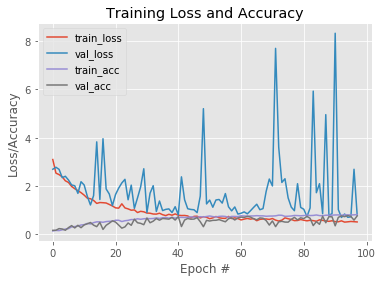

In [10]:
import matplotlib
matplotlib.use("Agg")
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.savefig("EmoTrain_1.png")
plt.show()

In [11]:
scores = model.evaluate(trainX, trainY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 


acc: 79.89%


In [12]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("EmoClassModel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("EmoClassWeights.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
# load json and create model
json_file = open('EmoClassModel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("EmoClassWeights.h5")
print("Loaded model from disk")
print('Model Summary:')
print(loaded_model.summary())

Loaded model from disk
Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32

In [14]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(testX, testY, verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

322/322 [==============================] - 5s 14ms/step
acc: 76.40%
